
# Árboles de Decisión — Banknote Authentication (UCI)

**Objetivos de la práctica**  
- Cargar el dataset  
- EDA  
- División *train/test* (70/30)  
- Entrenar un árbol de decisión  
- Comparar precisión en función de `max_depth`  
- Mostrar el árbol en **texto**  
- Visualizar **regiones de decisión** (con 2 *features*)  
- Construir **Matriz de Confusión** y métricas  
- Redactar una **interpretación final**


In [ ]:
# # Instalamos todas las dependencias necesarias (Si estamos usando un venv)
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn

  Using cached numpy-2.3.4-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.4-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.3 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]━━━━━━━━━━━ 2/3 [pandas]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --up

In [2]:

# 0) Imports y configuración si no tienes alguno de ellos, usa en la Terminal: pip install (nombre de la librería)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.grid'] = True



## 1) Cargar dataset y quedarnos con 2 *features*
Usaremos **variance** y **skewness** para poder dibujar regiones de decisión fácilmente.


In [3]:

# 1) Carga de datos
possible_paths = [
    'data_banknote_authentication.csv',
    '/kaggle/input/bank-note-authentication-uci-data/data_banknote_authentication.csv'
]

df = None
for p in possible_paths:
    try:
        df = pd.read_csv(p)
        break
    except Exception:
        pass

if df is None:
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
    cols = ['variance','skewness','curtosis','entropy','target']
    df = pd.read_csv(url, header=None, names=cols)

df.columns = [c.lower().strip() for c in df.columns]
if 'class' in df.columns and 'target' not in df.columns:
    df.rename(columns={'class':'target'}, inplace=True)

X = df[['variance','skewness']].values
y = df['target'].values

df.head()


,variance,skewness,curtosis,entropy,target
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0



## 2) EDA
Comprobamos tamaños, valores nulos, balance de clases y estadísticas descriptivas.
#### Pista: Mira la API de la librería Pandas para hacer un mejor EDA


Shape:
(1372, 5)

Valores nulos por columna:
variance    0
skewness    0
curtosis    0
entropy     0
target      0
dtype: int64

Balance de clases (target):
target
0    762
1    610
Name: count, dtype: int64

Informacion general del dataframe:
<bound method NDFrame.describe of       variance  skewness  curtosis  entropy  target
0      3.62160   8.66610   -2.8073 -0.44699       0
1      4.54590   8.16740   -2.4586 -1.46210       0
2      3.86600  -2.63830    1.9242  0.10645       0
3      3.45660   9.52280   -4.0112 -3.59440       0
4      0.32924  -4.45520    4.5718 -0.98880       0
...        ...       ...       ...      ...     ...
1367   0.40614   1.34920   -1.4501 -0.55949       1
1368  -1.38870  -4.87730    6.4774  0.34179       1
1369  -3.75030 -13.45860   17.5932 -2.77710       1
1370  -3.56370  -8.38270   12.3930 -1.28230       1
1371  -2.54190  -0.65804    2.6842  1.19520       1

[1372 rows x 5 columns]>

Estadísticas descriptivas (variance & skewness)


,variance,skewness
count,1372.000000,1372.000000
mean,0.433735,1.922353
std,2.842763,5.869047
min,-7.042100,-13.773100
25%,-1.773000,-1.708200
50%,0.496180,2.319650
75%,2.821475,6.814625
max,6.824800,12.951600


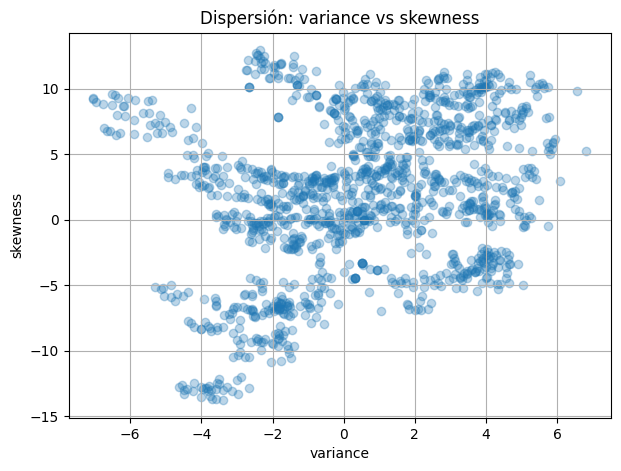

In [4]:

print("Shape:", )
print(df.shape)

print("\nValores nulos por columna:")
print(df.isna().sum())

# Dropping rows with missing values
df.dropna()

print("\nBalance de clases (target):")
print(df['target'].value_counts())

print("\nInformacion general del dataframe:")
print(df.describe)

print("\nEstadísticas descriptivas (variance & skewness)")
display(df[['variance','skewness']].describe())

##### Dispersión
plt.figure()
plt.scatter(df['variance'], df['skewness'], alpha=0.3)
plt.xlabel('variance'); plt.ylabel('skewness'); plt.title('Dispersión: variance vs skewness')
plt.show()



## 3) División en *train/test* (70/30)


In [5]:

X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape


((960, 2), (412, 2))


## 4) Árbol de decisión — modelo base


In [6]:

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred_tr = tree.predict(X_train)
y_pred_te = tree.predict(X_test)

acc_tr = accuracy_score(y_train, y_pred_tr)
acc_te = accuracy_score(y_test, y_pred_te)

print(f"Accuracy (train): {acc_tr:.3f}")
print(f"Accuracy (test) : {acc_te:.3f}")


Accuracy (train): 1.000
Accuracy (test) : 0.930


### Interpretación a priori de los Accuracy:

Podemos ver que el accuracy es 1, lo que significa que el modelo se ajusta a todos los valores de nuestro dataframe (sobreajuste)
Esto causará falsos positivos/falsos negativos a la hora de evaluar nuestro modelo. Lo que da lugar a este comportamiento es 
que no hemos pasado el argumento `max_depth` a nuestra funcion `DecisionTreeClasifier()` lo que hace el modelo recorra todos
y cada uno de los valores de nuestro dataframe



## 5) Precisión según `max_depth`


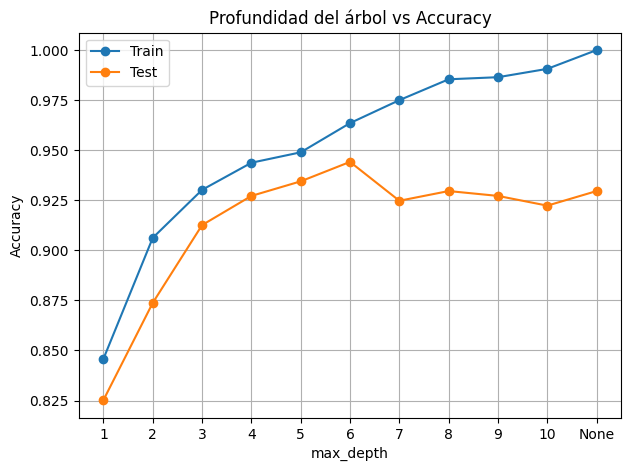

In [7]:

depths = [1,2,3,4,5,6,7,8,9,10,None]
train_scores, test_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(random_state=42, max_depth=d)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

x_labels = [str(d) if d is not None else 'None' for d in depths]

plt.figure()
plt.plot(range(len(depths)), train_scores, marker='o', label='Train')
plt.plot(range(len(depths)), test_scores, marker='o', label='Test')
plt.xticks(range(len(depths)), x_labels)
plt.xlabel('max_depth'); plt.ylabel('Accuracy')
plt.title('Profundidad del árbol vs Accuracy'); plt.legend(); plt.show()


### Interpretación los datos obtenidos:

Aquí vemos una gráfica con el Accuracy de nuestro arbol de decisión dependiendo de la profundidad que le pasamos a `max_depth`,
que va a ir del 1 al 10 y luego sin pasarle argumento (recorre todos los valores). Cuando nuestra profundidad es 1, 
tanto la exactitud de la parte del train como la del test es relativamente baja porque el árbol solo divide el dataset una vez
(algo similar a una regresión logística). A medida que vamos aumentando la profundidad, vemos como va subiendo la exactitud 
del train y del test, hasta que llegamos a la profundidad 7, donde la accuracy del árbol con el dataset de prueba empieza a 
disminuir. Cuando vemos este descenso y además la distancia entre la exactitud de train y test crece, podemos asumir que el 
modelo está empezando a sobreajustarse a los datos de entrenamiento lo que causa falsos positivos. Una vez dicho esto, parce
que la mejor opción para max_depth será 6, donde tiene más accuracy y tanto train y test están cerca.


## 6) Mostrar árbol en **texto** según variance y skewness (nuestras feature_names)
### Aquí elegiremos la mejor profundidad del árbol que observemos según el punto anterior y la pondremos en max_depth


In [14]:

best_tree = DecisionTreeClassifier(random_state=42, max_depth=6)
best_tree.fit(X_train, y_train)

tree_text = export_text(best_tree, feature_names=['variance','skewness'])
print(tree_text)


|--- variance <= 0.77
|   |--- skewness <= 5.36
|   |   |--- variance <= 0.32
|   |   |   |--- variance <= -0.26
|   |   |   |   |--- variance <= -1.78
|   |   |   |   |   |--- skewness <= 1.77
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- skewness >  1.77
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- variance >  -1.78
|   |   |   |   |   |--- variance <= -1.77
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- variance >  -1.77
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- variance >  -0.26
|   |   |   |   |--- skewness <= -0.03
|   |   |   |   |   |--- variance <= -0.03
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- variance >  -0.03
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- skewness >  -0.03
|   |   |   |   |   |--- class: 1
|   |   |--- variance >  0.32
|   |   |   |--- skewness <= 3.22
|   |   |   |   |--- variance <= 0.74
|   |   |   |   |   |--- skewness <= -2.11
|   |   |   |   |   |   |--- clas


## 7) Regiones de decisión (2D)


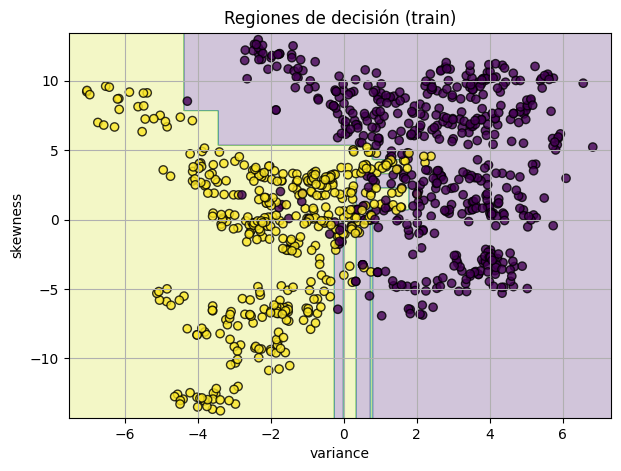

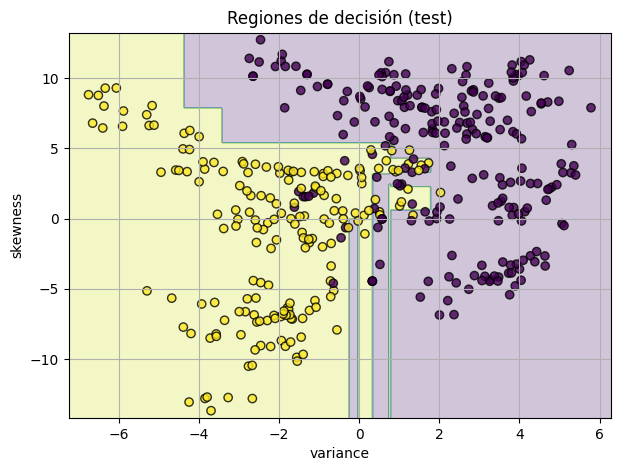

In [15]:

def plot_decision_regions_2d(model, X, y, title='Decision regions'):
    x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', alpha=0.8)
    plt.xlabel('variance'); plt.ylabel('skewness'); plt.title(title)
    plt.show()

plot_decision_regions_2d(best_tree, X_train, y_train, title='Regiones de decisión (train)')
plot_decision_regions_2d(best_tree, X_test, y_test, title='Regiones de decisión (test)')



## 8) Matriz de Confusión y métricas (calcula las principales métricas de la matriz de confusión: Accuracy, Precision, Recall, Specificity, FPR)
Filas = **Predicción** (Positivo/Negativo) · Columnas = **Realidad** (Positivo/Negativo)


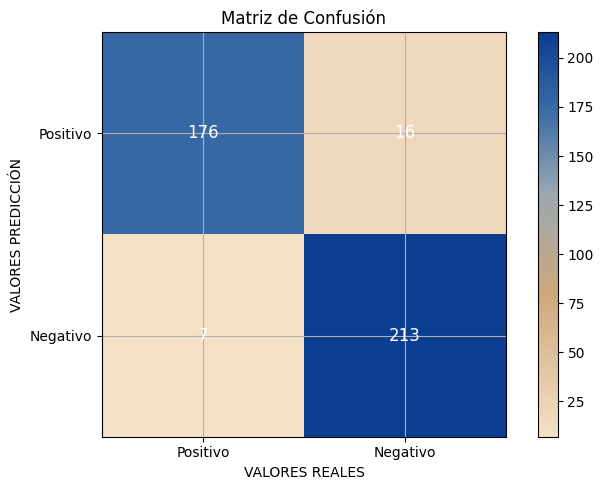

TP, TN, FP, FN = 176 213 16 7
Accuracy   : 0.944
Precision  : 0.917
Recall/TPR : 0.962
Specificity: 0.930
FPR        : 0.070


In [16]:
def safe_div(num, den):
    return float(num)/den if den!=0 else float('nan')

y_pred_best = best_tree.predict(X_test)

cm_official = confusion_matrix(y_test, y_pred_best, labels=[1,0])
TP, FN, FP, TN = cm_official.ravel()

cm_view = np.array([[TP, FP],
                    [FN, TN]])

brown_to_blue = LinearSegmentedColormap.from_list(
    "brown_to_blue",
    [
        (0.00, "#F4E1C6"),
        (0.35, "#CFA77B"),
        (0.60, "#9BA8B3"),
        (0.80, "#3C6EA6"),
        (1.00, "#0B3D91"),
    ],
    N=256
)

fig, ax = plt.subplots()
im = ax.imshow(cm_view, cmap=brown_to_blue)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Positivo','Negativo'])
ax.set_yticklabels(['Positivo','Negativo'])
ax.set_xlabel('VALORES REALES'); ax.set_ylabel('VALORES PREDICCIÓN')
plt.colorbar(im, ax=ax)

for i in range(2):
    for j in range(2):
        ax.text(j, i, int(cm_view[i, j]), ha='center', va='center', color='white', fontsize=12)

plt.title('Matriz de Confusión')
plt.tight_layout(); plt.show()

#### Saca las métricas pedidas en el enunciado del punto 8. Pista: hay una función que te lo saca todo ;)
accuracy = safe_div(TP + TN, cm_official.sum())
precision = safe_div(TP, TP + FP)
recall = safe_div(TP, TP + FN)          # Sensibilidad / TPR
specificity = safe_div(TN, TN + FP)     # Especificidad / TNR
fpr = safe_div(FP, FP + TN)             # 1 - Specificity

print('TP, TN, FP, FN =', TP, TN, FP, FN)
print(f'Accuracy   : {accuracy:.3f}')
print(f'Precision  : {precision:.3f}')
print(f'Recall/TPR : {recall:.3f}')
print(f'Specificity: {specificity:.3f}')
print(f'FPR        : {fpr:.3f}')


## 9) Preguntas finales:
- ¿En qué `max_depth` se logra **mejor rendimiento en test**? ¿Aparecerían señales de **sobreajuste** al aumentar la profundidad? ¿Por qué? 

	- Con `max_depth = 6` vemos el mejor rendimiento en `test`, y cuando aumentamos la profundidad vemos que `train` sigue 
	aumentando su accuracy mientras que `test` disminuye y se desestabiliza, lo que a priori es una señal de sobreajuste.

- Observa la **matriz de confusión**: ¿qué tipo de error domina (FP o FN)? ¿Qué significa que predomine FP o FN?
	
	- En este caso FP > FN lo que podríamos decir que es "optimista" (tiende mas a dar como positivos casos que en la realidad
	son negativos). Si fuese al contrario (FN > FP) diríamos que nuestro modelo es "pesimista".

- Añade las otras observaciones que consideres importante

	- Aunque hayamos visto que para nuestro dataframe, el árbol de decisión tenga el mejor rendimiento con `max_depth = 6`, si
	miramos las regiones de decisión vemos que hay demasiadas subdivisiones, lo que hará que seguramente falle más de lo esperado
	con otros casos fuera del dataframe. Si probamos con `max_depth = 3`, veremos que nuestro rendimiento para este dataframe
	en concreto decrece, aumentan un poco los FP y FN pero las regiones de decisión son mucho más limpias y seguramente se 
	adapten mejor a datos del mundo real.

